In [1]:
%run imports.ipynb

In [54]:
from scipy.stats import ttest_ind, linregress, pearsonr
from statsmodels.stats import multitest

In [8]:
cell_line_info = pd.read_csv('../note2/results/CCLE/sample_info.csv')
cell_line_info.shape

(1811, 26)

In [9]:
aml_cell_line_info = cell_line_info[(cell_line_info.primary_disease == 'Leukemia') & (cell_line_info.Subtype.str.contains('AML'))]
aml_cell_line_info.shape

(54, 26)

In [12]:
sra_run_table = pd.read_csv('../note2/results/CCLE/SraRunTable_SRP186687.txt')
sra_run_table = sra_run_table[sra_run_table['Assay Type'] == 'Bisulfite-Seq']

sra_run_table['Cell_Line'] = sra_run_table.Cell_Line.str.upper().str.replace('-', '').str.replace(' ', '').str.replace('.', '').str.replace('/' ,'')

/data/project/dohoon/miniconda3/envs/dnmt3a/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [13]:
cellline_name2depmap_id = {r['stripped_cell_line_name']: r['DepMap_ID'] for r in aml_cell_line_info.to_records()}

In [14]:
run2cellline = {r.Run:r.Cell_Line for r in sra_run_table.to_records()}

In [15]:
ctrp_per_cpd_avg = pd.read_csv('../note2/results/CCLE/v20.meta.per_assay_plate.txt', sep='\t')
ctrp_cell_lines = pd.read_csv('../note2/results/CCLE/v20.meta.per_cell_line.txt', sep='\t')
ctrp_compounds = pd.read_csv('../note2/results/CCLE/v20.meta.per_compound.txt', sep='\t')
ctrp_experiments = pd.read_csv('../note2/results/CCLE/v20.meta.per_experiment.txt', sep='\t')

ctrp_curves = pd.read_csv('../note2/results/CCLE/v20.data.curves_post_qc.txt', sep='\t').merge(ctrp_experiments, on='experiment_id')

master_ccl_id2ccl_name = {r.master_ccl_id:r.ccl_name for r in ctrp_cell_lines.to_records()}
master_cpd_id2cpd_name = {r.master_cpd_id:r.cpd_name for r in ctrp_compounds.to_records()}

ctrp_curves['ccl_name'] = ctrp_curves.master_ccl_id.map(master_ccl_id2ccl_name)
ctrp_curves['cpd_name'] = ctrp_curves.master_cpd_id.map(master_cpd_id2cpd_name)

In [18]:
ccl_names = set(ctrp_curves.ccl_name.str.upper())
m3_ccl_names = aml_cell_line_info[(aml_cell_line_info.lineage_sub_subtype == 'M3') | (aml_cell_line_info.lineage_sub_subtype.isnull())].stripped_cell_line_name.values

ctrp_ccl_names = [ccl.upper() for ccl in lpmi_summary.cell_line.unique() if pd.notnull(ccl) and (ccl.replace('-', '') in ccl_names) and (ccl.replace('-', '') not in m3_ccl_names)]

In [46]:
contexts = ['cgi', 'cpg_shore', 'cpg_shelf', 'promoter', 'methylation_canyon', 'exon', 'genebody', 'sine', 'line', 'ltr', 'bivalent_domain', 'bivalent_promoter', 'nonbivalent_promoter', 'nonbivalent_promoter_bivslop1000', 'all']

context_names = [
    'CpG island',
    'CpG shore',
    'CpG shelf',
    'Promoter',
    'Methylation canyon',
    'Exon',
    'Gene body',
    'SINE',
    'LINE',
    'LTR',
    'Bivalent domain',
    'Bivalent promoter',
    'Nonbivalent promoter',
    'Nonbivalent promoter (1000bp slopped)',
    'Genomewide'
]

### Save LPMD data

In [47]:
data = []

for context in contexts:
    concordance_fps = glob.glob(f'/data2/project/SNUH_DNMT3A/pipelines/DMD-CONTEXT/result/CCLE-RRBS/*.{context}.pairs.csv')

    # Make summary table.
    lpmd_summary = []
    names = ['chrom', 'pos1', 'pos2', 'distance', 'concordance', 'n_con', 'n_dis', 'depth', 'run']
    for fp in tqdm(concordance_fps):
        tmp = pd.read_csv(fp)
        tmp = tmp.groupby('distance').agg({'n_con': 'sum', 'n_dis': 'sum', 'run': 'first'}).reset_index()
        tmp['lpmd'] = tmp['n_dis'] / (tmp['n_dis'] + tmp['n_con'])

        lpmd_summary.append(tmp)

    lpmd_summary = pd.concat(lpmd_summary)
    lpmd_summary['cell_line'] = lpmd_summary.run.map(run2cellline)
    lpmd_summary['depmap_id'] = lpmd_summary.cell_line.map(cellline_name2depmap_id)

    # Aggregate lpmd by distance (2-24bp)
    d = lpmd_summary[lpmd_summary.distance <= MAX_DISTANCE].groupby('cell_line').agg({'n_con': 'sum', 'n_dis': 'sum'}).reset_index()
    d['lpmd'] = d.n_dis / (d.n_dis + d.n_con)

    ctrp_concordance_map = {r.cell_line.replace('-', ''):r.lpmd for r in d.to_records() if pd.notnull(r.cell_line)}
    ctrp_curves['lpmd'] = ctrp_curves.ccl_name.map(ctrp_concordance_map)
    ctrp_curves_aml = ctrp_curves[ctrp_curves.ccl_name.isin(ctrp_ccl_names)].copy()

    ctrp_result = defaultdict(list)

    ctrp_curves_aml['log_apparent_ec50_umol'] = np.log2(ctrp_curves_aml.apparent_ec50_umol + 1)
    ctrp_curves_aml['log_area_under_curve'] = np.log2(ctrp_curves_aml.area_under_curve + 1)
    ctrp_curves_aml['response'] = (ctrp_curves_aml.p4_baseline < 0.3)
    ctrp_curves_aml['area_under_curve_clipped'] = ctrp_curves_aml.area_under_curve.clip(lower=0, upper=15)

    d = ctrp_curves_aml[ctrp_curves_aml.cpd_name.isin(drugs)].drop_duplicates(['ccl_name', 'cpd_name'])[['ccl_name', 'cpd_name', 'lpmd', 'area_under_curve']]
    d['context'] = context
    data.append(d)
    
data = pd.concat(data)

100%|██████████| 34/34 [00:00<00:00, 112.84it/s]


In [48]:
data.to_csv('source_data/ccle_hma_response.csv', index=False)

In [55]:
drugs = [
    'RG-108',
    'decitabine',
    'decitabine:navitoclax (2:1 mol/mol)',
    'decitabine:carboplatin (1:1 mol/mol)',
    'selumetinib:decitabine (4:1 mol/mol)', 
    'azacitidine'
]

drugs_short = [
    'RG108',
    'decitabine',
    'decitabine_navitoclax_2_1',
    'decitabine_carboplatin_1_1',
    'selumetinib_decitabine_4_1',
    'azacitidine'
]
drugs_title = [
    'RG-108',
    'Decitabine',
    'Decitabine+Navitoclax\n(2:1 mol/mol)',
    'Decitabine+Carboplatin\n(1:1 mol/mol)',
#         'Selumetinib+Decitabine (4:1 mol/mol)',
#         'Azacitidine',
]


In [132]:
data = pd.read_csv('source_data/ccle_hma_response.csv')

for context, context_name in zip(contexts, context_names):
    fig = plt.figure(figsize=(6, 1.2))
    for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
        ax = fig.add_subplot(1, 4, i + 1)

        d = data[(data.context == context) & (data.cpd_name == drug)]
        sns.regplot(x=d['lpmd'], y=d['area_under_curve'], scatter_kws={'s': 3, 'color': '0.4'}, line_kws={'lw': 1, 'ls': '--', 'color': 'k'}, ax=ax)

        result = linregress(d['lpmd'], d['area_under_curve'])
        plt.text(0.05, 0.05, f'p={result.pvalue:.2g}\nr={result.rvalue:.2g}', ha='left', transform=ax.transAxes)

        ax.set_ylim([-0.5, 18])
        ax.set_xlim([d.lpmd.min() - 3e-3, d.lpmd.max() + 3e-3])
        
        if context == 'bivalent_domain':
            ax.set_xlabel('bivLPMD', fontsize=7)
        else:
            ax.set_xlabel(f'LPMD ({context_name})', fontsize=7)
        if i == 0:
            ax.set_ylabel('AUDRC', fontsize=7)
        else:
            ax.set_ylabel('')

        ax.set_title(drug_title, pad=5, fontsize=7)

    plt.subplots_adjust(wspace=0.3)
    save_figures(f'source_data_figures/hma_response_lpmd/hma_response.lpmd.{context}')
    plt.clf()

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

<Figure size 900x180 with 0 Axes>

### Draw curves for THP1 (exp_id 387) and HEL9217 (exp_id 700)

In [70]:
ctrp_raw = pd.read_csv('../note2/results/CCLE/v20.data.per_cpd_well.txt', sep='\t')

In [72]:
master_ccl_id2ccl_name = {r.master_ccl_id:r.ccl_name for r in ctrp_cell_lines.to_records()}
master_cpd_id2cpd_name = {r.master_cpd_id:r.cpd_name for r in ctrp_compounds.to_records()}

In [73]:
ctrp_raw['dmso_zscore'] = 2 ** ctrp_raw.dmso_zscore_log2.values
ctrp_raw['bsub_value'] = 2 ** ctrp_raw.bsub_value_log2.values

In [74]:
ctrp_raw['cpd_name'] = ctrp_raw.master_cpd_id.map(master_cpd_id2cpd_name)

In [75]:
ctrp_experiments['ccl_name'] = ctrp_experiments.master_ccl_id.map(master_ccl_id2ccl_name)

In [76]:
def get_curve_params(experiment_id, cpd_name):
    tmp = ctrp_curves_aml[(ctrp_curves_aml.experiment_id == experiment_id) & (ctrp_curves_aml.cpd_name == cpd_name)]
    
    p1 = 2 ** tmp.p1_center.values[0]
    p2 = 2 ** tmp.p2_slope.values[0]
    p3 = tmp.p3_total_decline.values[0]
    p4 = tmp.p4_baseline.values[0]
    
    return p1, p2, p3, p4

In [77]:
exp2baseline = dict(zip(ctrp_experiments.experiment_id, ctrp_experiments.baseline_signal))

### bivLPMD

In [109]:
low_lpmi_experiment_id = 387  # THP1
high_lpmi_experiment_id = 700  # HEL9217

data = []

for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
# for i, (drug, drug_short, drug_title) in enumerate(zip(['RG-108'], ['RG108'], ['RG-108'])):

    # High LPMI scatter
    high_baseline = exp2baseline[high_lpmi_experiment_id]
    high_curve_data = ctrp_raw[(ctrp_raw.experiment_id == high_lpmi_experiment_id) & (ctrp_raw.cpd_name == drug)].groupby('cpd_conc_umol').agg({'bsub_value': 'mean'}).reset_index()

    # Low LPMI scatter
    low_baseline = exp2baseline[low_lpmi_experiment_id]
    low_curve_data = ctrp_raw[(ctrp_raw.experiment_id == low_lpmi_experiment_id) & (ctrp_raw.cpd_name == drug)].groupby('cpd_conc_umol').agg({'bsub_value': 'mean'}).reset_index()
    
    high_curve_data['cell_line'] = 'HEL9217'
    low_curve_data['cell_line'] = 'THP1'
    
    high_curve_data['ctrp_experiment_id'] = 700
    low_curve_data['ctrp_experiment_id'] = 387
    
    high_curve_data['baseline'] = high_baseline
    low_curve_data['baseline'] = low_baseline
    
    d = pd.concat([high_curve_data, low_curve_data])
    d['drug'] = drug_short
    
    data.append(d)
    
data = pd.concat(data)

In [110]:
data.to_csv('source_data/ccle_bivLPMD_high_low_scatter.csv', index=False)

In [111]:
data

,cpd_conc_umol,bsub_value,cell_line,ctrp_experiment_id,baseline,drug
0,0.0081,1.023381,HEL9217,700,0.1195,RG108
1,0.0160,1.070702,HEL9217,700,0.1195,RG108
2,0.0320,1.056284,HEL9217,700,0.1195,RG108
3,0.0650,1.020394,HEL9217,700,0.1195,RG108
4,0.1300,1.032223,HEL9217,700,0.1195,RG108
...,...,...,...,...,...,...
11,4.2000,0.628052,THP1,387,0.1195,decitabine_carboplatin_1_1
12,8.3000,0.731312,THP1,387,0.1195,decitabine_carboplatin_1_1
13,17.0000,0.772669,THP1,387,0.1195,decitabine_carboplatin_1_1
14,33.0000,0.647282,THP1,387,0.1195,decitabine_carboplatin_1_1


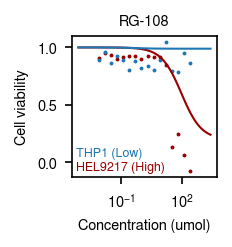

<Figure size 225x225 with 0 Axes>

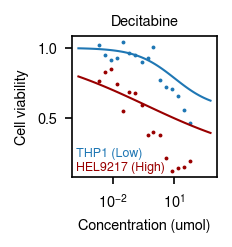

<Figure size 225x225 with 0 Axes>

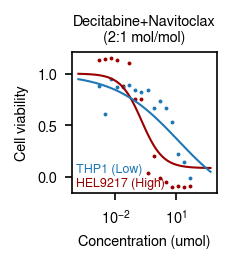

<Figure size 225x225 with 0 Axes>

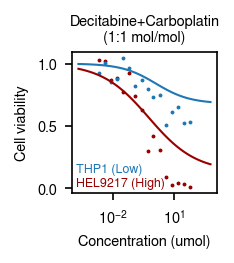

<Figure size 225x225 with 0 Axes>

In [129]:
data = pd.read_csv('source_data/ccle_bivLPMD_high_low_scatter.csv')

for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
    fig = plt.figure(figsize=(1.25, 1.25))
    ax = fig.add_subplot(111)
    
    d = data[data.drug == drug_short]
    
    high_curve_data = d[d.cell_line == 'HEL9217']
    high_experiment_id = high_curve_data.ctrp_experiment_id.values[0]
    high_baseline = high_curve_data.baseline.values[0]
    ax.scatter(
        high_curve_data.cpd_conc_umol,
        high_curve_data.bsub_value - high_baseline,
        c='#990000',
        s=3,
    )

    low_curve_data = d[d.cell_line == 'THP1']
    low_experiment_id = low_curve_data.ctrp_experiment_id.values[0]
    low_baseline = low_curve_data.baseline.values[0]
    ax.scatter(
        low_curve_data.cpd_conc_umol,
        low_curve_data.bsub_value - low_baseline,
        c='C0',
        s=3,
    )
    
    # High LPMD curve.
    p1, p2, p3, p4 = get_curve_params(experiment_id=high_experiment_id, cpd_name=drug)
    high_xmin, high_xmax = high_curve_data.cpd_conc_umol.min() / 10, high_curve_data.cpd_conc_umol.max() * 10

    high_lpmd_x = 10 **np.linspace(np.log10(high_xmin), np.log10(high_xmax), 100)
    high_lpmd_y = 1 + (p4 - 1) / (1 + (p1 / high_lpmi_x)**p2)

    ax.plot(high_lpmd_x, high_lpmd_y, c='#990000', label='HEL9217', lw=1)

    # Low LPMD curve.
    p1, p2, p3, p4 = get_curve_params(experiment_id=low_experiment_id, cpd_name=drug)
    low_xmin, low_xmax = low_curve_data.cpd_conc_umol.min() / 10, low_curve_data.cpd_conc_umol.max() * 10

    low_lpmd_x = 10 **np.linspace(np.log10(low_xmin), np.log10(low_xmax), 100)
    low_lpmd_y = 1 + (p4 - 1) / (1 + (p1 / low_lpmi_x)**p2)

    ax.plot(low_lpmd_x, low_lpmd_y, c='C0', label='THP1', lw=1)
    
    ax.set_xlabel('Concentration (umol)')
    ax.set_ylabel('Cell viability')
    ax.set_xscale('log')
    
    ax.set_title(drug_title, pad=5, fontsize=7)
#     ax.legend(frameon=False, loc='lower left')
    ax.text(0.03, 0.15, 'THP1 (Low)', c='C0', transform=ax.transAxes, fontsize=6)
    ax.text(0.03, 0.05, 'HEL9217 (High)', c='#990000', transform=ax.transAxes, fontsize=6)
    
    save_figures(f'source_data_figures/hma_response_lpmd/ccle_bivLPMD_high_low_scatter.{drug_short}')
    
    plt.show()
    plt.clf()

### SINE

In [122]:
low_experiment_id = 576  # KASUMI1
high_experiment_id = 694  # SIGM5

data = []

for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
# for i, (drug, drug_short, drug_title) in enumerate(zip(['RG-108'], ['RG108'], ['RG-108'])):

    # High LPMI scatter
    high_baseline = exp2baseline[high_lpmi_experiment_id]
    high_curve_data = ctrp_raw[(ctrp_raw.experiment_id == high_experiment_id) & (ctrp_raw.cpd_name == drug)].groupby('cpd_conc_umol').agg({'bsub_value': 'mean'}).reset_index()

    # Low LPMI scatter
    low_baseline = exp2baseline[low_lpmi_experiment_id]
    low_curve_data = ctrp_raw[(ctrp_raw.experiment_id == low_experiment_id) & (ctrp_raw.cpd_name == drug)].groupby('cpd_conc_umol').agg({'bsub_value': 'mean'}).reset_index()
    
    high_curve_data['cell_line'] = 'SIGM5'
    low_curve_data['cell_line'] = 'KASUMI1'
    
    high_curve_data['ctrp_experiment_id'] = high_experiment_id
    low_curve_data['ctrp_experiment_id'] = low_experiment_id
    
    high_curve_data['baseline'] = high_baseline
    low_curve_data['baseline'] = low_baseline
    
    d = pd.concat([high_curve_data, low_curve_data])
    d['drug'] = drug_short
    
    data.append(d)
    
data = pd.concat(data)

In [123]:
data.to_csv('source_data/ccle_sineLPMD_high_low_scatter.csv', index=False)

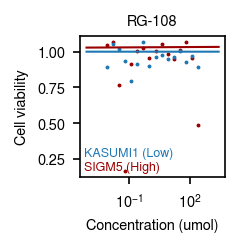

<Figure size 225x225 with 0 Axes>

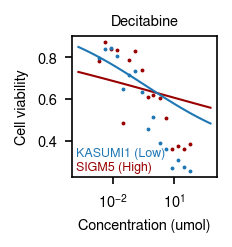

<Figure size 225x225 with 0 Axes>

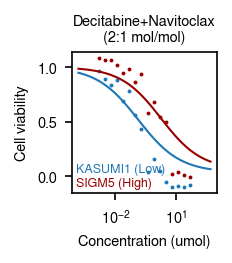

<Figure size 225x225 with 0 Axes>

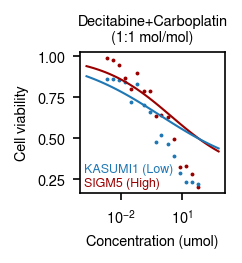

<Figure size 225x225 with 0 Axes>

In [128]:
data = pd.read_csv('source_data/ccle_sineLPMD_high_low_scatter.csv')

for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
    fig = plt.figure(figsize=(1.25, 1.25))
    ax = fig.add_subplot(111)
    
    d = data[data.drug == drug_short]
    
    high_curve_data = d[d.cell_line == 'SIGM5']
    high_experiment_id = high_curve_data.ctrp_experiment_id.values[0]
    high_baseline = high_curve_data.baseline.values[0]
    ax.scatter(
        high_curve_data.cpd_conc_umol,
        high_curve_data.bsub_value - high_baseline,
        c='#990000',
        s=3,
    )

    low_curve_data = d[d.cell_line == 'KASUMI1']
    low_experiment_id = low_curve_data.ctrp_experiment_id.values[0]
    low_baseline = low_curve_data.baseline.values[0]
    ax.scatter(
        low_curve_data.cpd_conc_umol,
        low_curve_data.bsub_value - low_baseline,
        c='C0',
        s=3,
    )
    
    # High LPMD curve.
    p1, p2, p3, p4 = get_curve_params(experiment_id=high_experiment_id, cpd_name=drug)
    high_xmin, high_xmax = high_curve_data.cpd_conc_umol.min() / 10, high_curve_data.cpd_conc_umol.max() * 10

    high_lpmd_x = 10 **np.linspace(np.log10(high_xmin), np.log10(high_xmax), 100)
    high_lpmd_y = 1 + (p4 - 1) / (1 + (p1 / high_lpmi_x)**p2)

    ax.plot(high_lpmd_x, high_lpmd_y, c='#990000', label='HEL9217', lw=1)

    # Low LPMD curve.
    p1, p2, p3, p4 = get_curve_params(experiment_id=low_experiment_id, cpd_name=drug)
    low_xmin, low_xmax = low_curve_data.cpd_conc_umol.min() / 10, low_curve_data.cpd_conc_umol.max() * 10

    low_lpmd_x = 10 **np.linspace(np.log10(low_xmin), np.log10(low_xmax), 100)
    low_lpmd_y = 1 + (p4 - 1) / (1 + (p1 / low_lpmi_x)**p2)

    ax.plot(low_lpmd_x, low_lpmd_y, c='C0', label='THP1', lw=1)
    
    ax.set_xlabel('Concentration (umol)')
    ax.set_ylabel('Cell viability')
    ax.set_xscale('log')
    
    ax.set_title(drug_title, pad=5, fontsize=7)
    ax.text(0.03, 0.15, 'KASUMI1 (Low)', c='C0', transform=ax.transAxes, fontsize=6)
    ax.text(0.03, 0.05, 'SIGM5 (High)', c='#990000', transform=ax.transAxes, fontsize=6)
    
    save_figures(f'source_data_figures/hma_response_lpmd/ccle_sineLPMD_high_low_scatter.{drug_short}')
    
    plt.show()
    plt.clf()